## Постановка задачи
Загрузим данные и разделим их на обучающие и проверочные в соотношении 80/20.

Используем Keras для построения нейросети с линейным, сверточными слоями и слоями подвыборки. Проверим, как повышают эффективность обучения нормализация данных и отсев.

Обучим модель, используя последовательную загрузку данных. Проведем оценку качества предсказания по коэффициенту сходства.

Данные:
* https://video.ittensive.com/machine-learning/clouds/train.csv.gz (54 Мб)
* https://video.ittensive.com/machine-learning/clouds/train_images_small.tar.gz (212 Мб)

Соревнование: https://www.kaggle.com/c/understanding_cloud_organization/

© ITtensive, 2020

### Подключение библиотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from skimage import io
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Using TensorFlow backend.


### Используемые функции

In [2]:
image_x = 525 # 525
image_y = 350 # 350
image_ch = 3 # 3
def mask_rate (a, x, y):
    b = a//1400 + 0.0
    return np.round(x*(b*x//2100) + y*(a%1400)//1400).astype("uint32")

def calc_mask (px, x=image_x, y=image_y):
    p = np.array([int(n) for n in px.split(' ')]).reshape(-1,2)
    mask = np.zeros(x*y, dtype='uint8')
    for i, l in p:
        mask[mask_rate(i, x, y) - 1:mask_rate(l+i, x, y)] = 1
    return mask.reshape(y,x).transpose()

def calc_dice (x):
    dice = 0
    px = x["EncodedPixels"] 
    if px != px and x["target"] == 0:
        dice = 1
    elif px == px and x["target"] == 1:
        mask = calc_mask(px).flatten()
        target = np.ones(image_x*image_y, dtype='uint8')
        dice += 2*np.sum(target[mask==1])/(np.sum(target)+np.sum(mask))
    return dice

def load_y (df):
    return np.array(df["EncodedPixels"].notnull().astype("int8")).reshape(len(df), 1)

def load_x (df):
    x = [[]]*len(df)
    for j, file in enumerate(df["Image"]):
        x[j] = io.imread(os.path.join(filesDir, file))
    return np.array(x).reshape(len(df), image_y, image_x, image_ch)

def load_data (df, batch_size):
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(df):
            limit = min(batch_end, len(df))
            yield (load_x(df[batch_start:limit]),
                   load_y(df[batch_start:limit]))
            batch_start += batch_size   
            batch_end += batch_size

def draw_prediction (prediction):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1,1,1)
    ax.hist(prediction[0])
    ax.set_title("Fish")
    plt.show()

### Загрузка данных

In [3]:
data = pd.read_csv('https://video.ittensive.com/machine-learning/clouds/train.csv.gz')

In [4]:
data["Image"] = data["Image_Label"].str.split("_").str[0]
data["Label"] = data["Image_Label"].str.split("_").str[1]
data.drop(labels=["Image_Label"], axis=1, inplace=True)
data_fish = data[data["Label"] == "Fish"]
print (data_fish.head())

                                        EncodedPixels        Image Label
0   264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg  Fish
4   233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg  Fish
8   3510 690 4910 690 6310 690 7710 690 9110 690 1...  0031ae9.jpg  Fish
12                                                NaN  0035239.jpg  Fish
16  2367966 18 2367985 2 2367993 8 2368002 62 2369...  003994e.jpg  Fish


### Разделение данных
Разделим всю выборку на 2 части случайным образом: 80% - для обучения модели, 20% - для проверки точности модели.

In [5]:
train, test = train_test_split(data_fish, test_size=0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
del data
print (train.head())

                                           EncodedPixels        Image Label
6104                                                 NaN  4669e71.jpg  Fish
8476                                                 NaN  60aa201.jpg  Fish
6216   332608 448 334008 448 335408 448 336808 448 33...  476f864.jpg  Fish
20804  125255 656 126655 656 128055 656 129455 656 13...  eff8789.jpg  Fish
4700                                                 NaN  36198e2.jpg  Fish


### Генератор данных для обучения
Данные всех изображений могут не поместиться в оперативную память, поэтому будем обучать нейросеть последовательно, пакетами.

In [6]:
filesDir = "train_images_small"
batch_size = 50

### Сверточная нейросеть
Создадим модель. Архитектура в общем виде:

INPUT -> [[CONV -> RELU] * N -> POOL?] * M -> [FC -> RELU] * K -> FC * L

In [7]:
model = Sequential([
    Conv2D(32, (3,3), input_shape=(image_y, image_x, image_ch),
          kernel_initializer='glorot_uniform', strides=(2,2)),
    Activation("relu"),
    BatchNormalization(),
    Dropout(0.5),
    Conv2D(32, (3,3),
           kernel_initializer='glorot_uniform', strides=(2,2)),
    Activation("relu"),
    BatchNormalization(),
    Dropout(0.5),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Activation("softmax"),
    Dense(1)
])

W0314 21:49:40.229383  9288 deprecation_wrapper.py:119] From c:\users\nikolay\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0314 21:49:40.349390  9288 deprecation.py:506] From c:\users\nikolay\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.compile(optimizer=optimizers.Nadam(lr=0.02),
             loss="mean_absolute_error")

### Предсказание значений

In [9]:
model.fit_generator(load_data(train, batch_size),
            epochs=50, steps_per_epoch=len(train)//batch_size)

Epoch 1/50
88/88 [==============================] - 1357s 15s/step - loss: 0.5035
Epoch 2/50
88/88 [==============================] - 1356s 15s/step - loss: 0.5060
Epoch 3/50
88/88 [==============================] - 1359s 15s/step - loss: 0.5054
Epoch 4/50
88/88 [==============================] - 1267s 14s/step - loss: 0.5129
Epoch 5/50
88/88 [==============================] - 1211s 14s/step - loss: 0.5120
Epoch 6/50
88/88 [==============================] - 1204s 14s/step - loss: 0.5142
Epoch 7/50
88/88 [==============================] - 1207s 14s/step - loss: 0.5341
Epoch 8/50
88/88 [==============================] - 1216s 14s/step - loss: 0.5228
Epoch 9/50
88/88 [==============================] - 1206s 14s/step - loss: 0.5180
Epoch 10/50
88/88 [==============================] - 1213s 14s/step - loss: 0.5178
Epoch 11/50
88/88 [==============================] - 1208s 14s/step - loss: 0.5075
Epoch 12/50
88/88 [==============================] - 1206s 14s/step - loss: 0.5372
Epoch 13/50
8

In [10]:
prediction = model.predict_generator(load_data(test, 1),
                            steps=len(test), verbose=1)

1110/1110 [==============================] - 148s 133ms/step


In [11]:
prediction = np.transpose(prediction)

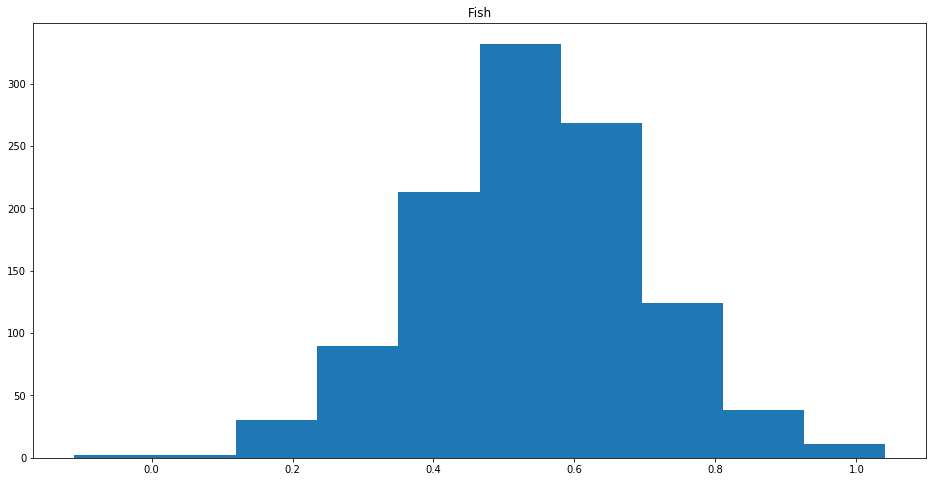

In [12]:
draw_prediction(prediction)

In [20]:
test["target"] = (prediction[0] >= 0.95).astype("int8")
print (test[test["target"]>0][["EncodedPixels","target"]].head(100))

                                           EncodedPixels  target
19652  1124605 556 1126005 556 1127405 556 1128805 55...       1
15796                                                NaN       1
16904  851201 395 851597 2 851609 8 852601 400 853009...       1
12196                                                NaN       1
21716  96 777 1496 777 2896 777 4296 777 5696 777 709...       1
14268  845 447 2245 447 3645 447 5045 447 6445 447 78...       1
13092                                                NaN       1
18664                                                NaN       1


### Оценка по Дайсу
Пока будем считать, что при определении типа облака на изображении, оно целиком размещено на фотографии: т.е. область облака - это все изображение.

Нет облаков - 0.5, MLP - 0.3, CONV3-32x2,POOL2 - 0.46

In [21]:
dice = test.apply(calc_dice, axis=1, result_type="expand")
print ("Keras, (CONV3-32x2,POOL2):", round(dice.mean(), 3))

Keras, (CONV3-32x2,POOL2): 0.488
